In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from numpy import transpose as t
from numpy.linalg import inv
import math
from scipy.special import gamma
from scipy.special import loggamma
from numpy import log

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.head()

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,ad_si_3,Appr_0,Appr_1,Appr_2,서울,transformed_Hammer_price,skyscraper
0,2.823222,-1.435719,1766037301,2,760000000,35,0,1,0,0,0,0,1,0,175.394072,30
1,1.278944,-2.646606,152946867,2,971889999,35,0,1,0,0,0,0,1,0,182.985785,51
2,-0.530059,2.631658,11326510,3,93399999,77,0,0,0,1,0,0,1,0,121.888773,30
3,-0.706458,0.081095,183581724,2,256899000,105,0,0,0,1,0,0,1,0,145.387692,30
4,-0.533846,0.986816,45887671,2,158660000,28,0,0,0,1,0,0,1,0,133.700341,30


In [4]:
X = data.drop(['Hammer_price','transformed_Hammer_price','ad_si_3','Appr_2'],axis=1)
y = data['transformed_Hammer_price']

In [5]:
X.head()

,PC1,PC2,Claim_price,Auction_count,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,Appr_0,Appr_1,서울,skyscraper
0,2.823222,-1.435719,1766037301,2,35,0,1,0,0,0,0,30
1,1.278944,-2.646606,152946867,2,35,0,1,0,0,0,0,51
2,-0.530059,2.631658,11326510,3,77,0,0,0,0,0,0,30
3,-0.706458,0.081095,183581724,2,105,0,0,0,0,0,0,30
4,-0.533846,0.986816,45887671,2,28,0,0,0,0,0,0,30


In [6]:
#scaling
for i in X.columns:
    m = np.mean(X[i])
    s = np.std(X[i])
    X[i] = X[i].apply(lambda x : (x-m)/s)

In [7]:
class Model:
    
    def z_function(self,data,category_index):
        p = data.shape[1]
        category = [i for i in range(p)]
        Ncategory = []
        for i in category_index:
            Ncategory.append(i)
            for j in i:
                category.remove(j)
        x = [[i] for i in category]
        for i in Ncategory:
            x.append(i)
        result = []
        cnt=0
        for i in range(len(x)): 
            count = len(list(combinations(x,i+1))) 
            for j in range(count):   
                z = [0]*p
                for k in range(i+1):
                    if len(list(combinations(x,i+1))[j][k]) == 1: #(1,2)
                        z[list(combinations(x,i+1))[j][k][0]] = 1
                    else:
                        for m in range(len(list(combinations(x,i+1))[j][k])):#(1,(2,3,4))
                            z[list(combinations(x,i+1))[j][k][m]] = 1
                result.append(z)
        return result
    
    def sig(self,X,y):
        X = np.array(X)
        n = X.shape[0]
        yhat = X@inv(t(X)@X)@t(X)@y
        res = y-yhat
        return sum(res**2)/n
        
    
    def posterior(self,X,y,category_index,g):
        nu0 = 1 
        z = Model.z_function(self,X,category_index)
        y = np.array(y)
        l = []
        for i in z:
            i = np.array(i)
            Xz = X.iloc[:,np.where(i==1)[0]]
            n,p = Xz.shape
            Xz = np.array(Xz)
            sig0 = Model.sig(self,Xz,y)
            ssr = t(y)@(np.eye(n)-g/(g+1)*Xz@inv(t(Xz)@Xz)@t(Xz))@y
            loglikelihood = (-n/2)*log(np.pi)+loggamma((nu0+n)/2)-loggamma(nu0/2)-p/2*log(1+g)+nu0/2*log(nu0*sig0)-(nu0+n)/2*log(nu0*sig0+ssr)
            l.append(loglikelihood)
        l = l/sum(l)
        return l

In [8]:
m = Model()

In [9]:
z = m.z_function(X,[[5,6,7],[8,9]])

In [10]:
posterior = m.posterior(X,y,[[5,6,7],[8,9]],X.shape[0])

In [11]:
result = pd.DataFrame()
result['model'] = z
result['posterior'] = posterior

In [12]:
result.head()

,model,posterior
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.001954
1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.001955
2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.001955
3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0.001955
4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0.001955


In [13]:
np.argmax(posterior)

509

In [14]:
result.iloc[np.argmax(posterior),:]

model        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
posterior                                 0.00196
Name: 509, dtype: object

In [15]:
from statsmodels.formula.api import ols

In [16]:
res = ols('transformed_Hammer_price~PC2+Claim_price+Auction_count+Final_First_auction_data+ad_si_0+ad_si_1+ad_si_2+Appr_0+Appr_1+서울+skyscraper',data=data).fit()

In [17]:
X['PC1']=1
X.rename(columns={'PC1':'intercept'})
Xz = X.iloc[:,:]
n=Xz.shape[0]
g=n
s0 = res.mse_resid
nu0=1
ssr=t(y).dot(np.eye(n)-Xz.dot(inv(t(Xz).dot(Xz)).dot(t(Xz)))*g/(g+1)).dot(y)
beta=res.params[:]

In [18]:
from scipy.stats import gamma
from scipy.stats import multivariate_normal

BETA = []

for i in range(1000):
    precision_MC = gamma.rvs(a = nu0+n, scale = (nu0+n)/((nu0*s0)+ssr),size=1)
    cov_MC = 1/precision_MC * inv(t(Xz).dot(Xz))
    beta_MC = multivariate_normal.rvs(mean = beta * g/(g+1), cov=cov_MC*g/(g+1),size=1)
    BETA.append(beta_MC)
    
pd.DataFrame(BETA).mean()

0     87.368541
1     -1.632595
2      0.000023
3     -2.945322
4      0.005012
5     24.100314
6      9.487440
7     30.645763
8      7.222672
9     29.947249
10    14.348095
11     1.803751
dtype: float64

In [19]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     transformed_Hammer_price   R-squared:                       0.544
Model:                                  OLS   Adj. R-squared:                  0.541
Method:                       Least Squares   F-statistic:                     200.0
Date:                      Wed, 02 Jun 2021   Prob (F-statistic):          1.16e-304
Time:                              16:57:14   Log-Likelihood:                -7501.3
No. Observations:                      1855   AIC:                         1.503e+04
Df Residuals:                          1843   BIC:                         1.509e+04
Df Model:                                11                                         
Covariance Type:                  nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   87.4158      7.414     11.791      0.000      72.875     101.957
PC2                         -1.6335      0.345     -4.733      0.000      -2.310      -0.957
Claim_price               1.024e-09   2.94e-10      3.485      0.001    4.48e-10     1.6e-09
Auction_count               -2.9464      0.424     -6.950      0.000      -3.778      -2.115
Final_First_auction_data     0.0049      0.002      1.992      0.046    7.56e-05       0.010
ad_si_0                     24.1131      1.288     18.717      0.000      21.586      26.640
ad_si_1                      9.4923      0.799     11.878      0.000       7.925      11.060
ad_si_2                     30.6621      1.627     18.842      0.000      27.471      33.854
Appr_0                       7.2263      1.893      3.818      0.000       3.514      10.938
Appr_1                      29.9635     13.958      2.147      0.032       2.589      57.338
서울                          14.3558      0.750     19.152      0.000      12.886      15.826
skyscraper                   1.8042      0.242      7.443      0.000       1.329       2.280
==============================================================================
Omnibus:                      197.368   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.788
Skew:                          -0.718   Prob(JB):                     1.35e-75
Kurtosis:                       4.548   Cond. No.                     5.01e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
tdat = pd.read_csv("final_test1.csv",encoding='cp949')

In [21]:
tdat.head()

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,Appr_0,Appr_1,서울,skyscraper,transformed_Hammer_price
0,-0.018118,-1.283313,1087000000,7,0,1058,0,0,0,0,0,0,30,136.406777
1,-0.138741,-1.148936,1087000000,6,0,1030,0,0,0,0,0,0,30,138.332108
2,-0.021238,-1.279988,1087000000,7,0,1058,0,0,0,0,0,0,30,136.367237
3,-0.021238,-1.279988,1087000000,7,0,1058,0,0,0,0,0,0,30,136.367237
4,-0.021238,-1.279988,1087000000,7,0,1058,0,0,0,0,0,0,30,136.367237


In [22]:
X1 = tdat.drop(['Hammer_price','transformed_Hammer_price'],axis=1)
y1 = tdat['transformed_Hammer_price']

In [23]:
tdat1 = tdat[['PC2','Claim_price','Auction_count','Final_First_auction_data','ad_si_0','ad_si_1','ad_si_2','Appr_0','Appr_1','서울','skyscraper']]

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
plt.rc('font', family='NanumBarunGothic') 

In [25]:
data123 = pd.read_csv('Auction_master_train.csv')

In [26]:
def outlier(data123):
    q1, q3 = np.percentile(data123,[25,75])
    iqr = q3-q1
    lb = q1 - (iqr*1.5)
    ub = q3 + (iqr*1.5)
    
    return np.where((data123>ub)|(data123<lb))

tmp = data123['addr_si'].unique()
data123 = data123.reset_index()

d = []
for i in tmp:
    ind = outlier(data123[data123['addr_si']==i]['Hammer_price'])
    ind2 = list(data123[data123['addr_si']==i].iloc[ind[0],:]['index'])
    if len(ind2) != 0 :
        d = d+ind2

data123 = data123.drop(index=d)

In [27]:
lambda_boxcox = boxcox(data123['Hammer_price'])[1]

In [28]:
hammer = res.predict(tdat1)

In [29]:
from scipy.special import inv_boxcox
prehammer = inv_boxcox(hammer, lambda_boxcox)

In [30]:
pd.options.display.float_format = '{:.5f}'.format
prehammer

0     130737061.86478
1     146495693.26738
2     130705581.04241
3     130705581.04241
4     130705581.04241
            ...      
815   379810978.68628
816   313125014.50153
817   305676048.08398
818   340084858.59215
819   345474717.76295
Length: 820, dtype: float64

In [31]:
y11 = inv_boxcox(y1, lambda_boxcox)

In [32]:
y11.head()

0   178012877.47702
1   192945462.08392
2   177716613.52416
3   177716613.52416
4   177716613.52416
Name: transformed_Hammer_price, dtype: float64

In [33]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(y11,prehammer))

204843592.9058807

In [34]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',10000)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


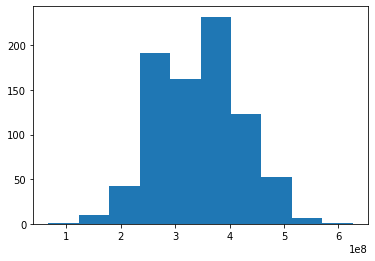

In [35]:
plt.hist(y11)
plt.show()

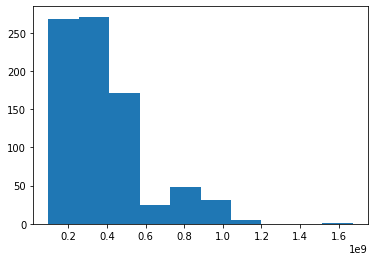

In [36]:
plt.hist(prehammer)
plt.show()

### 몬테카를로 모델에 의해 나온 계수들로 hammer price 계산

### scale을 잘못한거같긴 한데 방법을 모르겠습니다ㅠ
intercept term은 어디?

In [37]:
data.head()

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,ad_si_3,Appr_0,Appr_1,Appr_2,서울,transformed_Hammer_price,skyscraper
0,2.82322,-1.43572,1766037301,2,760000000,35,0,1,0,0,0,0,1,0,175.39407,30
1,1.27894,-2.64661,152946867,2,971889999,35,0,1,0,0,0,0,1,0,182.98579,51
2,-0.53006,2.63166,11326510,3,93399999,77,0,0,0,1,0,0,1,0,121.88877,30
3,-0.70646,0.08109,183581724,2,256899000,105,0,0,0,1,0,0,1,0,145.38769,30
4,-0.53385,0.98682,45887671,2,158660000,28,0,0,0,1,0,0,1,0,133.70034,30


In [38]:
tdat.head()

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,Appr_0,Appr_1,서울,skyscraper,transformed_Hammer_price
0,-0.01812,-1.28331,1087000000,7,0,1058,0,0,0,0,0,0,30,136.40678
1,-0.13874,-1.14894,1087000000,6,0,1030,0,0,0,0,0,0,30,138.33211
2,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724
3,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724
4,-0.02124,-1.27999,1087000000,7,0,1058,0,0,0,0,0,0,30,136.36724


In [48]:
X1 = X1[['PC2','Claim_price','Auction_count','Final_First_auction_data','ad_si_0','ad_si_1','ad_si_2','Appr_0','Appr_1','서울','skyscraper']]

### Clame_price계수가 튀는 관계로 이 베타값만 Frequentist version

In [49]:
X1['a'] = -1.632595
X1['b'] = 1.024e-09
X1['c'] = -2.945322
X1['d'] = 0.005012
X1['e'] = 24.100314
X1['f'] = 9.487440
X1['g'] = 30.645763
X1['h'] = 7.222672
X1['i'] = 29.947249
X1['j'] = 14.348095
X1['k'] = 1.803751
X1['l'] = 87.368541

In [50]:
hammer2=[]
for i in range(820):
    hammer2.append((X1['PC2'][i]*X1['a'][i])+(X1['Claim_price'][i]*X1['b'][i])+(X1['Auction_count'][i]*X1['c'][i])+(X1['Final_First_auction_data'][i]*X1['d'][i])+(X1['ad_si_0'][i]*X1['e'][i])+(X1['ad_si_1'][i]*X1['f'][i])+(X1['ad_si_2'][i]*X1['g'][i])+(X1['Appr_0'][i]*X1['h'][i])+(X1['Appr_1'][i]*X1['i'][i])+(X1['서울'][i]*X1['j'][i])+(X1['skyscraper'][i]*X1['k'][i]) + X1['l'][i])

In [51]:
hammer2

[129.37473125360515,
 131.96033358120584,
 129.3693036746677,
 129.3693036746677,
 129.3693036746677,
 129.3693036746677,
 131.96033358120584,
 133.0905016317559,
 136.42042000388258,
 136.64786223016105,
 136.76834816852184,
 133.6729528029062,
 139.2576160540882,
 132.86650156053355,
 138.79880547156625,
 135.7703654075953,
 136.32051443024093,
 129.92488345230387,
 135.40841213231113,
 136.41071879547286,
 122.55703992860722,
 135.87892791490933,
 137.9447819736396,
 137.95368647170622,
 137.8721036964811,
 137.38695995265715,
 135.81845686777388,
 137.75389141562385,
 132.99691768228388,
 137.36717359361856,
 136.33251391582002,
 136.5317270355632,
 138.4000826667739,
 136.26282313831922,
 136.53844929440328,
 136.91714353927608,
 133.37101694159932,
 136.47960992224728,
 136.64395508972314,
 135.96865940728577,
 135.666459916321,
 139.7480373315318,
 137.51136165228135,
 136.63533418841644,
 137.29032089999563,
 136.81892292402466,
 134.79657814916192,
 144.16565952153448,
 140.85

In [52]:
prehammer2 = inv_boxcox(hammer2, lambda_boxcox)

In [53]:
pd.options.display.float_format = '{:.5f}'.format

(array([268., 271., 171.,  25.,  48.,  31.,   5.,   0.,   0.,   1.]),
 array([9.64693101e+07, 2.54148874e+08, 4.11828438e+08, 5.69508001e+08,
        7.27187565e+08, 8.84867129e+08, 1.04254669e+09, 1.20022626e+09,
        1.35790582e+09, 1.51558538e+09, 1.67326495e+09]),
 <BarContainer object of 10 artists>)

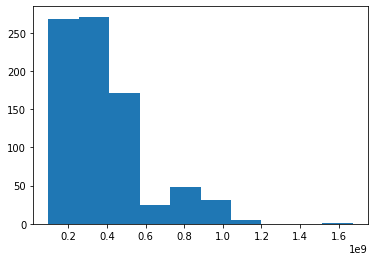

In [54]:
plt.hist(prehammer)

(array([268., 271., 171.,  25.,  48.,  31.,   5.,   0.,   0.,   1.]),
 array([9.63659106e+07, 2.53629136e+08, 4.10892361e+08, 5.68155586e+08,
        7.25418811e+08, 8.82682036e+08, 1.03994526e+09, 1.19720849e+09,
        1.35447171e+09, 1.51173494e+09, 1.66899816e+09]),
 <BarContainer object of 10 artists>)

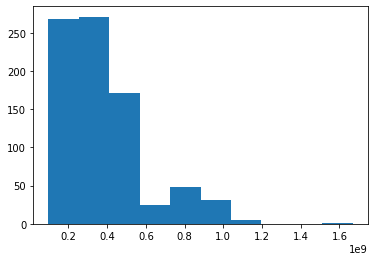

In [55]:
plt.hist(prehammer2)

In [56]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(prehammer2,prehammer))

1047052.8577768629